# Optimal Growth III: Time Iteration

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline

from interpolation import interp
from quantecon.optimize import brentq
from numba import njit, jitclass, float64

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

In [3]:

opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                α=0.4, 
                β=0.96, 
                μ=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.μ, self.s = α, β, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))
       

    def f(self, k):
        "The production function"
        return k**self.α
       

    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return 1/c

    def u_prime_inv(self, c):
        "Inverse of u'"
        return 1/c

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  # Remove the CWD from sys.path while we load stuff.


In [4]:
@njit
def euler_diff(c, σ, y, og):
    """
    Set up a function such that the root with respect to c,
    given y and σ, is equal to Kσ(y).

    """

    β, shocks, grid = og.β, og.shocks, og.grid
    f, f_prime, u_prime = og.f, og.f_prime, og.u_prime

    # First turn σ into a function via interpolation
    σ_func = lambda x: interp(grid, σ, x)

    # Now set up the function we need to find the root of.
    vals = u_prime(σ_func(f(y - c) * shocks)) * f_prime(y - c) * shocks
    return u_prime(c) - β * np.mean(vals)

In [5]:
@njit
def K(σ, og):
    """
    The Coleman-Reffett operator

     Here og is an instance of OptimalGrowthModel.
    """

    β = og.β
    f, f_prime, u_prime = og.f, og.f_prime, og.u_prime
    grid, shocks = og.grid, og.shocks

    σ_new = np.empty_like(σ)
    for i, y in enumerate(grid):
        # Solve for optimal c at y
        c_star = brentq(euler_diff, 1e-10, y-1e-10, args=(σ, y, og))[0]
        σ_new[i] = c_star

    return σ_new

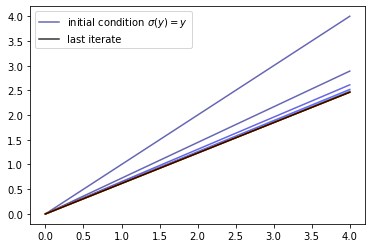

In [6]:
og = OptimalGrowthModel()
grid = og.grid

n = 15
σ = grid.copy()  # Set initial condition

fig, ax = plt.subplots()
lb = 'initial condition $\sigma(y) = y$'
ax.plot(grid, σ, color=plt.cm.jet(0), alpha=0.6, label=lb)

for i in range(n):
    σ = K(σ, og)
    ax.plot(grid, σ, color=plt.cm.jet(i / n), alpha=0.6)

# Update one more time and plot the last iterate in black
σ = K(σ, og)
ax.plot(grid, σ, color='k', alpha=0.8, label='last iterate')

ax.legend()

plt.show()

In [7]:
def solve_model_time_iter(model,    # Class with model information
                          σ,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, model)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

In [8]:
σ_init = np.copy(og.grid)
σ = solve_model_time_iter(og, σ_init)


Converged in 11 iterations.


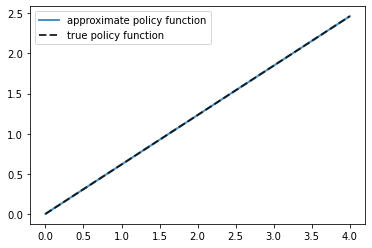

In [9]:
fig, ax = plt.subplots()

ax.plot(og.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(og.grid, σ_star(og.grid, og.α, og.β), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()

In [10]:
np.max(np.abs(σ - σ_star(og.grid, og.α, og.β)))

2.5329106213334285e-05

In [11]:
%%timeit -n 3 -r 1
σ = solve_model_time_iter(og, σ_init, verbose=False)

224 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [12]:


opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('μ', float64),          # Shock location parameter
    ('γ', float64),          # Preference parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel_CRRA:

    def __init__(self,
                α=0.4, 
                β=0.96, 
                μ=0,
                s=0.1,
                γ=1.5, 
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.α, self.β, self.γ, self.μ, self.s = α, β, γ, μ, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))
       

    def f(self, k):
        "The production function."
        return k**self.α

    def u(self, c):
        "The utility function."
        return c**(1 - self.γ) / (1 - self.γ)

    def f_prime(self, k):
        "Derivative of f."
        return self.α * (k**(self.α - 1))

    def u_prime(self, c):
        "Derivative of u."
        return c**(-self.γ)

    def u_prime_inv(c):
        return c**(-1 / self.γ)

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  # This is added back by InteractiveShellApp.init_path()


In [13]:
og_crra = OptimalGrowthModel_CRRA()


Converged in 13 iterations.


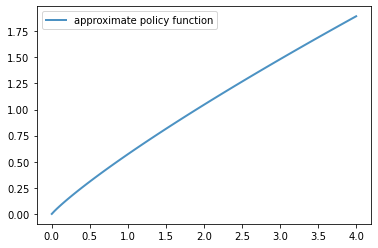

Wall time: 2.39 s


In [14]:
%%time
σ = solve_model_time_iter(og_crra, σ_init)


fig, ax = plt.subplots()

ax.plot(og.grid, σ, lw=2,
        alpha=0.8, label='approximate policy function')

ax.legend()
plt.show()